# Numerical evaluation of root-finding, topological ordering, and edge pruning

Code by Jacqueline Maasch | April 2024

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
import warnings
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from dowhy import gcm
from dowhy.gcm.util.general import set_random_seed
from os import listdir
from os.path import isfile, join
#import igraph as ig
import CausalDisco
from CausalDisco.analytics import (
    var_sortability,
    r2_sortability,
    snr_sortability,
    r2coeff,
    order_alignment
)

# Custom scripts.
#from root_id import RootID
import Root_Algo
import path_tracing
from path_tracing import EdgeDiscovery

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


/Users/jmaasch/anaconda3/envs/icp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def plot_nx(adjacency_matrix,
            labels,
            figsize = (5,5),
            dpi = 75,
            node_size = 800,
            arrow_size = 10):

    '''
    Plot graph given adjacency matrix.
    '''
    
    g = nx.from_numpy_array(adjacency_matrix, create_using = nx.DiGraph)
    plt.figure(figsize = figsize, dpi = dpi)  
    nx.draw_circular(g, 
                     node_size = node_size, 
                     node_color = "pink",
                     labels = dict(zip(list(range(len(labels))), labels)), 
                     arrowsize = arrow_size,
                     with_labels = True)
    plt.show()
    plt.close()

In [3]:
def get_ci(results: list,
           z: float = 1.96,
           return_mean: bool = True) -> tuple:

    '''
    Default is 95% confidence interval.
    '''

    mean = np.mean(results)
    se = stats.sem(results)
    ci = [mean - (z * se), mean + (z * se)]
    if return_mean:
        return mean, ci
    return ci

In [4]:
# https://www.pywhy.org/dodiscover/dev/auto_examples/plot_pc_alg.html
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html
class MyCustomModel(gcm.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        # We don't really need this actually.
        return MyCustomModel(self.coefficient)

def sample_from_dag(G, n = 1000, scale = True):

    '''
    Sample data from DGP defined by networkx graph G.
    '''
    
    #nx.draw_shell(G, 
    #              node_color = "pink",
    #              node_size = 800, 
    #              arrowsize = 10,
    #              with_labels = True)
    #plt.show()
    #plt.close()

    # Define causal model.
    causal_model = gcm.ProbabilisticCausalModel(G)
    params = np.random.uniform(low = -1.2, high = 1.5, size = len(nodes))
    for node,p in zip(nodes,params):
        if node in root_idx:
            #causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.binom, p = p, n = 1))
            causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1))
        else:
            causal_model.set_causal_mechanism(
                    node,
                    gcm.AdditiveNoiseModel(
                        #prediction_model = gcm.ml.create_linear_regressor(),
                        prediction_model = MyCustomModel(1),
                        #noise_model = gcm.ScipyDistribution(stats.binom, p = p, n = 1),
                        noise_model = gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1),
                    ),
                )

    # "Fit here would not really fit parameters, since we don't do anything in the fit method.
    # Here, we only need this to ensure that each FCM has the correct local hash (i.e., we
    # get an inconsistency error if we would modify the graph afterwards without updating
    # the FCMs). Having an empty data set is a small workaround, since all models are pre-defined."
    gcm.fit(causal_model, pd.DataFrame(columns = nodes))
    
    # Sample the observational data.
    data = gcm.draw_samples(causal_model, num_samples = n)

    # Columns are shuffled by DoWhy; put back in order w.r.t. order of adjacency matrix.
    data = data[nodes]
        
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        
    return data

## Read data

In [5]:
# Erdos-Renyi graphs.
df_5n_5m = pd.read_csv("data/erdos_renyi/erdos_renyi_5n_5m.csv")

In [6]:
display(df_5n_5m.head(10))

,X1,X2,X3,X4,X5,Replicate
0,0,1,0,1,1,1
1,0,0,0,1,0,1
2,0,0,0,0,0,1
3,0,0,0,0,1,1
4,0,0,0,0,0,1
5,0,0,1,1,1,2
6,0,0,0,1,0,2
7,0,0,0,1,0,2
8,0,0,0,0,0,2
9,0,0,0,0,0,2


## Process data

In [7]:
# Extract adjacency matrices.
n = 5
df_5n_5m = df_5n_5m.drop(columns = "Replicate")
adj_matrices = [df_5n_5m[i:i+n].to_numpy() for i in range(0,df_5n_5m.shape[0],n)]

array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

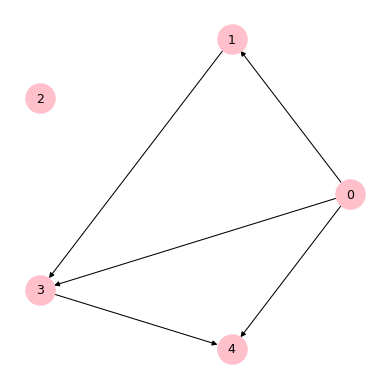

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

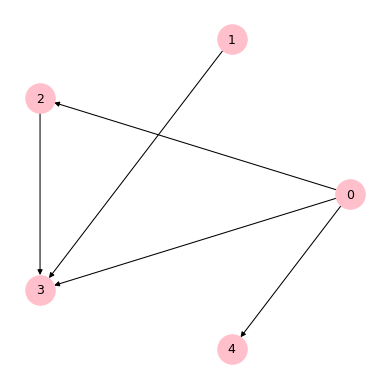

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

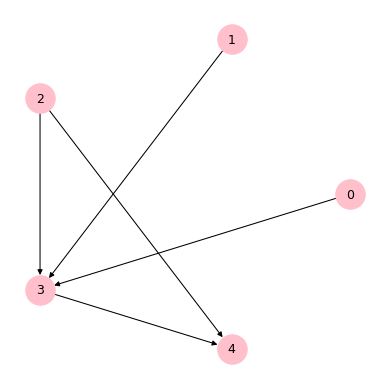

array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

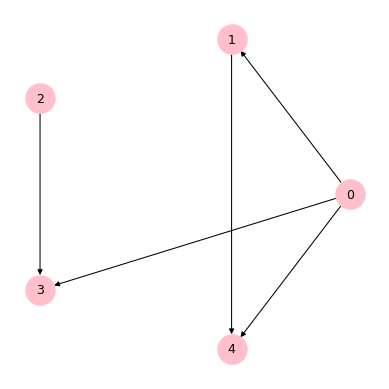

array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

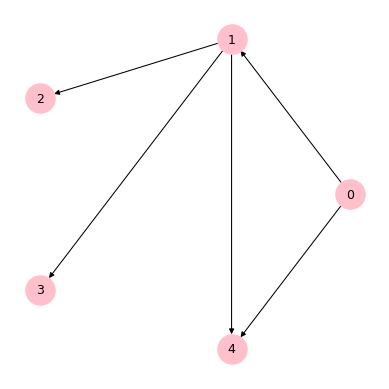

array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

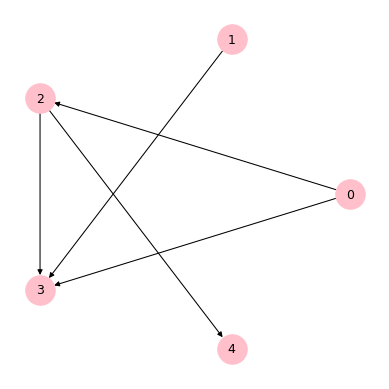

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

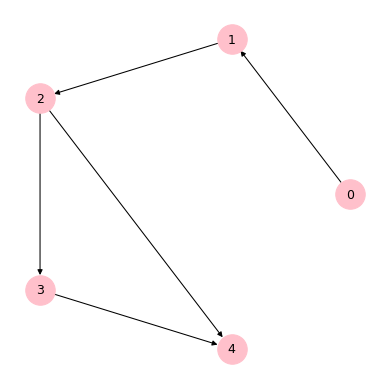

array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

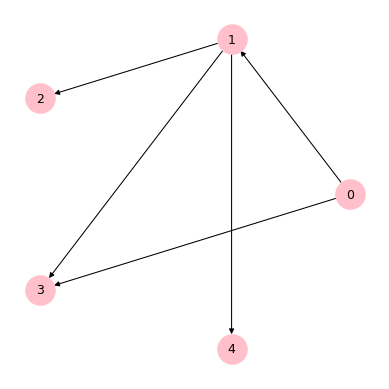

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

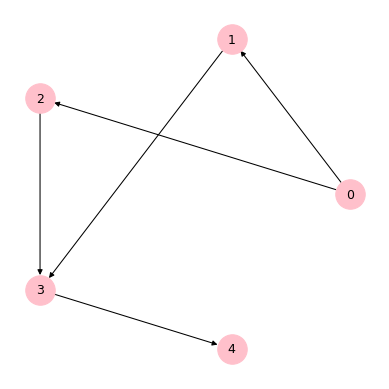

array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

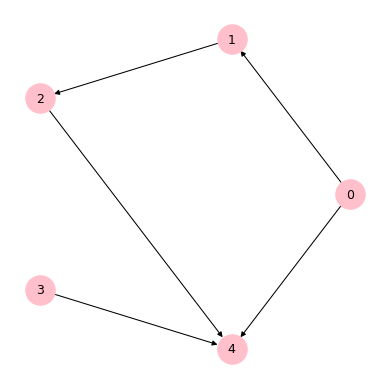

In [8]:
for adj in adj_matrices:
    display(adj)
    plot_nx(adj, labels = range(adj.shape[1]))

## Sample from distribution

In [9]:
%%capture
#set_random_seed(1234)

samples_500 = []
samples_1k = []
samples_5k = []
samples_10k = []
samples_20k = []
roots_true = []
graphs = []

samples_500_r2 = []
samples_1k_r2 = []
samples_5k_r2 = []
samples_10k_r2 = []
samples_20k_r2 = []

samples_500_var = []
samples_1k_var = []
samples_5k_var = []
samples_10k_var = []
samples_20k_var = []

for adj in adj_matrices:

    # Identify true roots from adjacency matrix.
    nodes = range(adj.shape[1])
    column_sums = adj.sum(axis = 0)
    root_idx = np.where(column_sums == 0)[0]
    roots_true.append(root_idx)

    # Construct graph from adjacency matrix.
    G = nx.from_numpy_array(adj, create_using = nx.DiGraph)
    node_map = dict(zip(range(adj.shape[1]), nodes))
    G = nx.relabel_nodes(G, node_map, copy = True)
    graphs.append(G)

    # Sample data.
    sample_500 = sample_from_dag(G, n = 500, scale = True)
    samples_500.append(sample_500)
    samples_500_r2.append(r2_sortability(X = sample_500, W = adj))
    samples_500_var.append(var_sortability(X = sample_500, W = adj))

    sample_1k = sample_from_dag(G, n = 1000, scale = True)
    samples_1k.append(sample_1k)
    samples_1k_r2.append(r2_sortability(X = sample_1k, W = adj))
    samples_1k_var.append(var_sortability(X = sample_1k, W = adj))

    sample_5k = sample_from_dag(G, n = 5000, scale = True)
    samples_5k.append(sample_5k)
    samples_5k_r2.append(r2_sortability(X = sample_5k, W = adj))
    samples_5k_var.append(var_sortability(X = sample_5k, W = adj))

    sample_10k = sample_from_dag(G, n = 10000, scale = True)
    samples_10k.append(sample_10k)
    samples_10k_r2.append(r2_sortability(X = sample_10k, W = adj))
    samples_10k_var.append(var_sortability(X = sample_10k, W = adj))
    
    sample_20k = sample_from_dag(G, n = 20000, scale = True)
    samples_20k.append(sample_20k)
    samples_20k_r2.append(r2_sortability(X = sample_20k, W = adj))
    samples_20k_var.append(var_sortability(X = sample_20k, W = adj))

In [10]:
len(adj_matrices)

In [11]:
r2_all = [samples_500_r2, samples_1k_r2, samples_5k_r2, samples_10k_r2, samples_20k_r2]
sizes = [500, 1000, 5000, 10000, 20000]

for i in range(len(r2_all)):
    print("\n----", sizes[i], "----")
    mean, ci = get_ci(r2_all[i])
    print("Mean R2-sortability: {} [{},{}]".format(round(mean, 2), round(ci[0], 2), round(ci[1], 2)))


---- 500 ----
Mean R2-sortability: 0.4 [0.29,0.52]

---- 1000 ----
Mean R2-sortability: 0.39 [0.28,0.5]

---- 5000 ----
Mean R2-sortability: 0.37 [0.23,0.5]

---- 10000 ----
Mean R2-sortability: 0.4 [0.25,0.55]

---- 20000 ----
Mean R2-sortability: 0.41 [0.28,0.54]


In [12]:
var_all = [samples_500_var, samples_1k_var, samples_5k_var, samples_10k_var, samples_20k_var]
sizes = [500, 1000, 5000, 10000, 20000]

for i in range(len(var_all)):
    print("\n----", sizes[i], "----")
    mean, ci = get_ci(var_all[i])
    print("Mean var-sortability: {} [{},{}]".format(round(mean, 2), round(ci[0], 2), round(ci[1], 2)))


---- 500 ----
Mean var-sortability: 0.43 [0.28,0.59]

---- 1000 ----
Mean var-sortability: 0.52 [0.41,0.64]

---- 5000 ----
Mean var-sortability: 0.44 [0.3,0.57]

---- 10000 ----
Mean var-sortability: 0.38 [0.26,0.51]

---- 20000 ----
Mean var-sortability: 0.51 [0.35,0.66]


## Find roots

### n = 500


--- 0 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

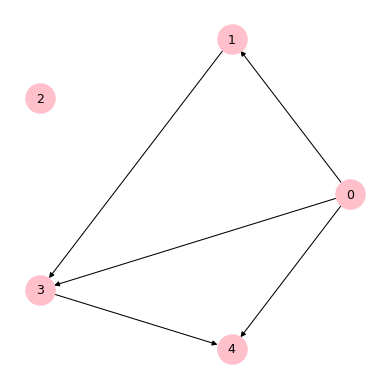


Runtime : 0.042 seconds
Predicted roots : [1, 1, 1, 1, 1]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 0.4
F1              : 0.5714285714285715
Precision       : 0.4
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

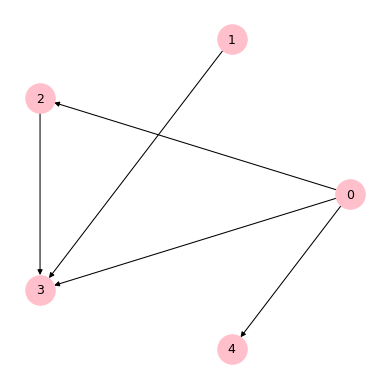


Runtime : 0.111 seconds
Predicted roots : [1, 1, 1, 1, 1]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 0.4
F1              : 0.5714285714285715
Precision       : 0.4
Recall          : 1.0

--- 2 ---



array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

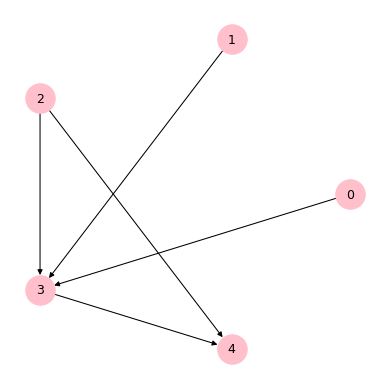


Runtime : 0.03 seconds
Predicted roots : [1, 1, 1, 0, 1]
True roots      : [1, 1, 1, 0, 0]
Accuracy        : 0.8
F1              : 0.8571428571428571
Precision       : 0.75
Recall          : 1.0

--- 3 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

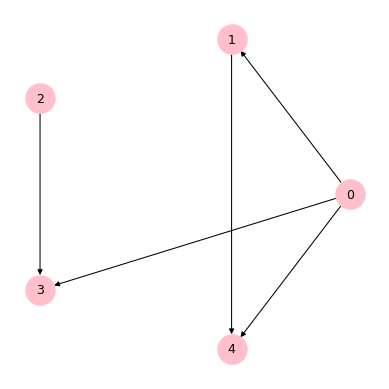


Runtime : 0.033 seconds
Predicted roots : [1, 1, 1, 0, 1]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 0.6
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 4 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

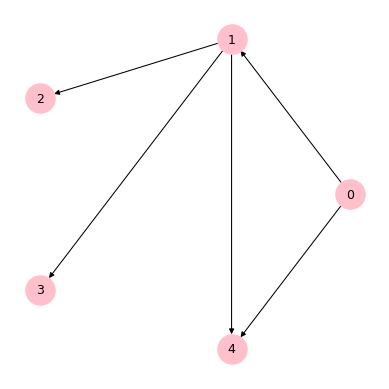


Runtime : 0.041 seconds
Predicted roots : [0, 1, 1, 1, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.2
F1              : 0.0
Precision       : 0.0
Recall          : 0.0

--- 5 ---



array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

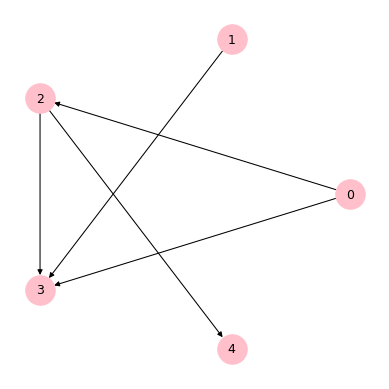


Runtime : 0.035 seconds
Predicted roots : [1, 1, 1, 1, 1]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 0.4
F1              : 0.5714285714285715
Precision       : 0.4
Recall          : 1.0

--- 6 ---



array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

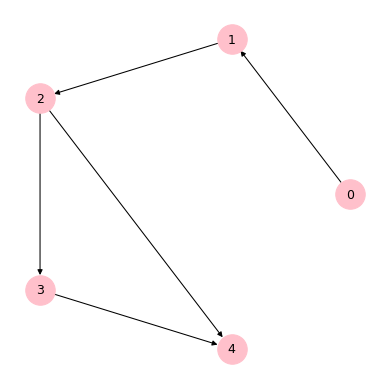


Runtime : 0.038 seconds
Predicted roots : [1, 1, 1, 0, 1]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.4
F1              : 0.4
Precision       : 0.25
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

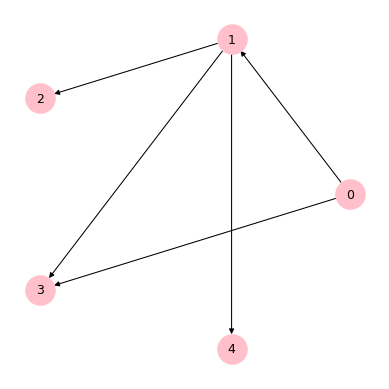


Runtime : 0.038 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 8 ---



array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

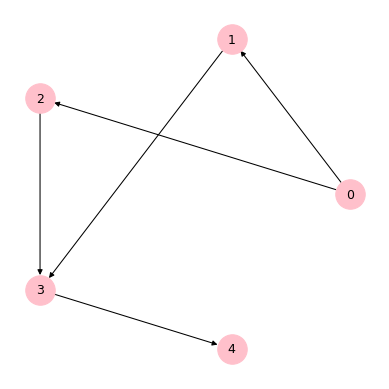


Runtime : 0.039 seconds
Predicted roots : [1, 1, 1, 1, 1]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.2
F1              : 0.33333333333333337
Precision       : 0.2
Recall          : 1.0

--- 9 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

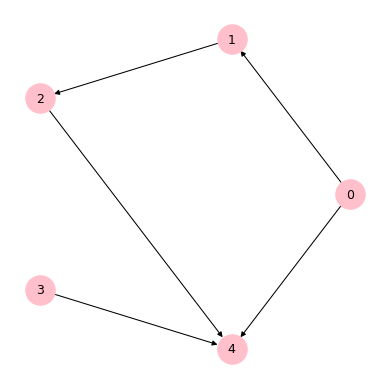


Runtime : 0.032 seconds
Predicted roots : [1, 1, 1, 1, 1]
True roots      : [1, 0, 0, 1, 0]
Accuracy        : 0.4
F1              : 0.5714285714285715
Precision       : 0.4
Recall          : 1.0

Mean accuracy  : 0.4600000000000001
Mean F1        : 0.520952380952381
Mean precision : 0.38
Mean recall    : 0.9


In [13]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_500)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_500[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

### n = 1000


--- 0 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

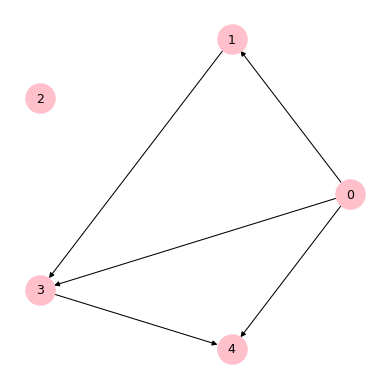


Runtime : 0.277 seconds
Predicted roots : [1, 1, 1, 1, 0]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 0.6
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

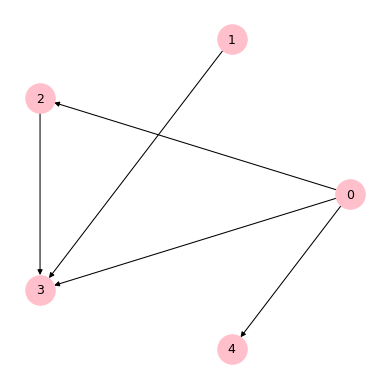


Runtime : 0.209 seconds
Predicted roots : [1, 1, 0, 1, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.8
Precision       : 0.6666666666666666
Recall          : 1.0

--- 2 ---



array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

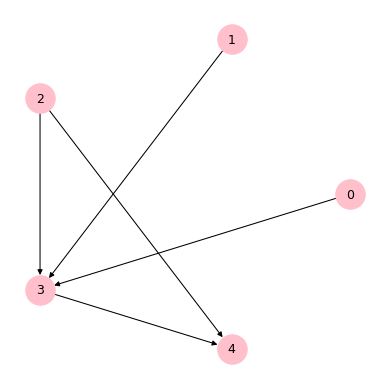


Runtime : 0.23 seconds
Predicted roots : [1, 1, 1, 1, 0]
True roots      : [1, 1, 1, 0, 0]
Accuracy        : 0.8
F1              : 0.8571428571428571
Precision       : 0.75
Recall          : 1.0

--- 3 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

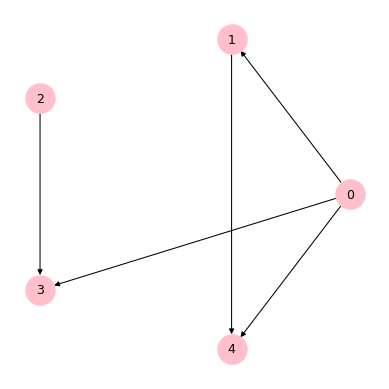


Runtime : 0.265 seconds
Predicted roots : [1, 0, 1, 0, 1]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 0.8
F1              : 0.8
Precision       : 0.6666666666666666
Recall          : 1.0

--- 4 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

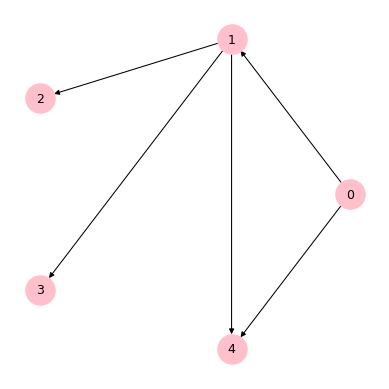


Runtime : 0.267 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

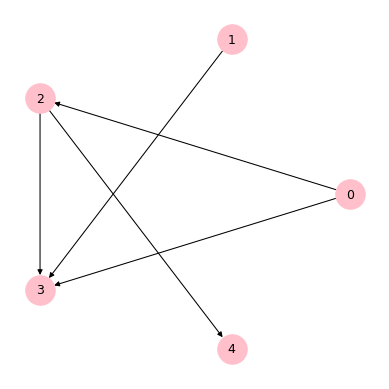


Runtime : 0.249 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 6 ---



array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

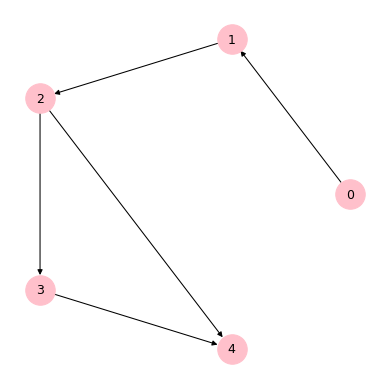


Runtime : 0.31 seconds
Predicted roots : [1, 0, 0, 0, 1]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

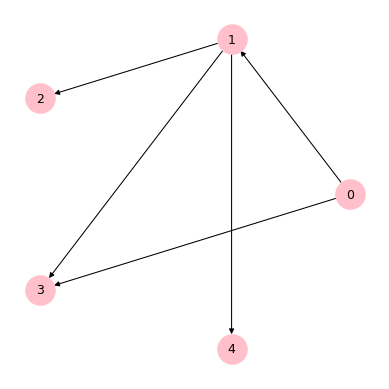


Runtime : 0.276 seconds
Predicted roots : [1, 1, 1, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.6
F1              : 0.5
Precision       : 0.3333333333333333
Recall          : 1.0

--- 8 ---



array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

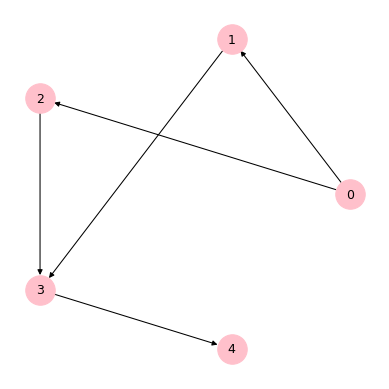


Runtime : 0.267 seconds
Predicted roots : [1, 0, 0, 0, 1]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 9 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

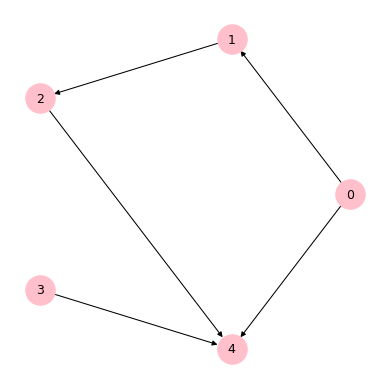


Runtime : 0.218 seconds
Predicted roots : [1, 0, 0, 1, 0]
True roots      : [1, 0, 0, 1, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

Mean accuracy  : 0.82
Mean F1        : 0.7957142857142857
Mean precision : 0.6916666666666667
Mean recall    : 1.0


In [14]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_1k)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_1k[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

### n = 5000


--- 0 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

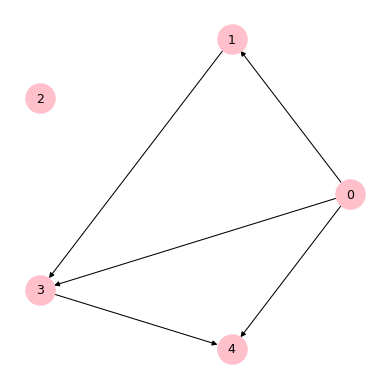


Runtime : 3.462 seconds
Predicted roots : [1, 0, 1, 0, 0]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

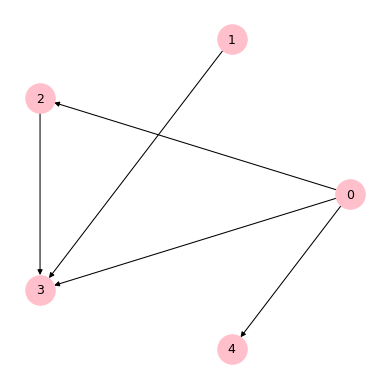


Runtime : 3.315 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 2 ---



array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

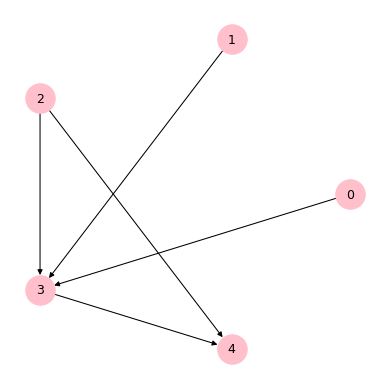


Runtime : 3.201 seconds
Predicted roots : [1, 1, 1, 0, 0]
True roots      : [1, 1, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 3 ---



array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

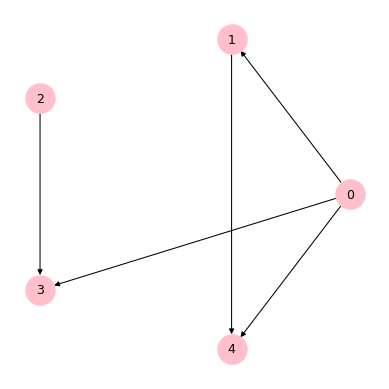


Runtime : 3.48 seconds
Predicted roots : [1, 0, 1, 0, 0]
True roots      : [1, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 4 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

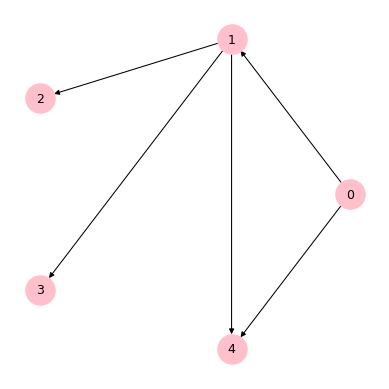


Runtime : 3.6 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

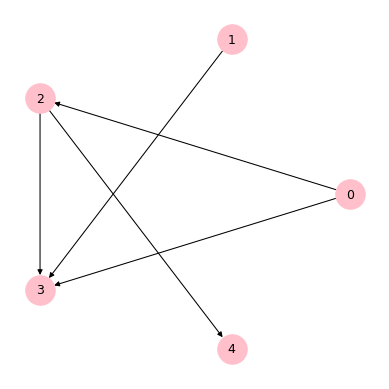


Runtime : 3.229 seconds
Predicted roots : [1, 1, 0, 0, 0]
True roots      : [1, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 6 ---



array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

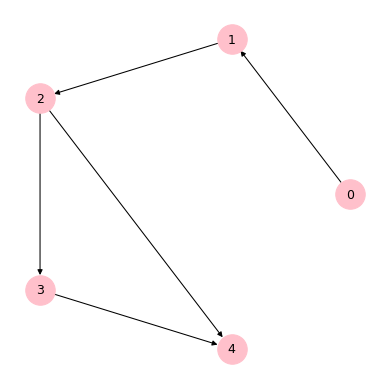


Runtime : 3.63 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

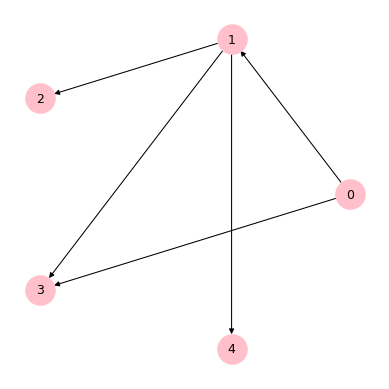


Runtime : 3.537 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 8 ---



array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

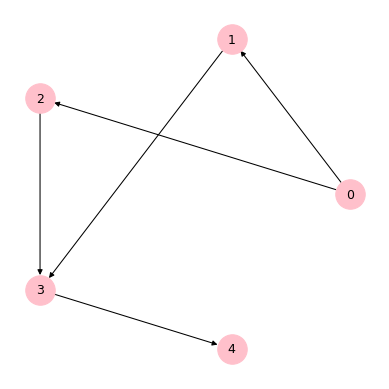


Runtime : 3.599 seconds
Predicted roots : [1, 0, 0, 0, 0]
True roots      : [1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 9 ---



array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

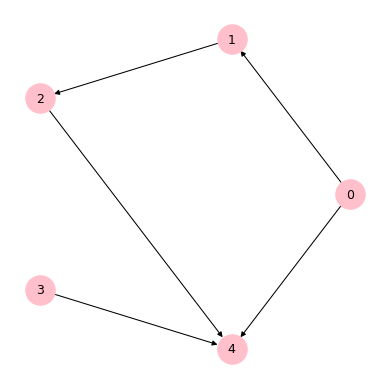


Runtime : 3.553 seconds
Predicted roots : [1, 0, 0, 1, 0]
True roots      : [1, 0, 0, 1, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

Mean accuracy  : 1.0
Mean F1        : 1.0
Mean precision : 1.0
Mean recall    : 1.0


In [15]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_5k)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_5k[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

## Edge pruning

In [23]:
parents_correct_total = 0
children_correct_total = 0

for i in range(len(adj_matrices)):
    print("\n---", i, "---\n")
    graph = graphs[i]
    data = samples_5k[i]
    adj = adj_matrices[i]
    true_sort = list(nx.topological_sort(graph))
    ed = EdgeDiscovery(adjacency_matrix = adj)
    start = time.time()
    pred_parents, pred_children = ed.path_tracing(true_sort, 
                                                  data, 
                                                  cit_test = "oracle", 
                                                  alpha = 0.01)
    print("Edge discovery complete in {}s.".format(round(time.time() - start, 4)))

    true_parents_sets = []
    true_children_sets = []
    for j in range(adj.shape[0]):
        true_parents = set(np.where(adj[:,j] == 1)[0])
        true_parents_sets.append(true_parents)
        true_children = set(np.where(adj[j,:] == 1)[0])
        true_children_sets.append(true_children)

    parents_correct = all([x == y for x,y in zip(true_parents_sets,pred_parents)])
    parents_correct_total += parents_correct
    children_correct = all([x == y for x,y in zip(true_children_sets,pred_children)])
    children_correct_total += children_correct

    print("True parents       :", true_parents_sets)
    print("Predicted parents  :", pred_parents)
    print("Parents correct    :", parents_correct)
    print("True children      :", true_children_sets)
    print("Predicted children :", pred_children)
    print("Children correct   :", children_correct)

print("\nFraction parents correct  :", parents_correct_total / len(adj_matrices))
print("Fraction children correct :", children_correct_total / len(adj_matrices))


--- 0 ---

Edge discovery complete in 0.0036s.
True parents       : [set(), {0}, set(), {0, 1}, {0, 3}]
Predicted parents  : [set(), {0}, set(), {0, 1}, {0, 3}]
Parents correct    : True
True children      : [{1, 3, 4}, {3}, set(), {4}, set()]
Predicted children : [{1, 3, 4}, {3}, set(), {4}, set()]
Children correct   : True

--- 1 ---

Edge discovery complete in 0.0023s.
True parents       : [set(), set(), {0}, {0, 1, 2}, {0}]
Predicted parents  : [set(), set(), {0}, {0, 1, 2}, {0}]
Parents correct    : True
True children      : [{2, 3, 4}, {3}, {3}, set(), set()]
Predicted children : [{2, 3, 4}, {3}, {3}, set(), set()]
Children correct   : True

--- 2 ---

Edge discovery complete in 0.0023s.
True parents       : [set(), set(), set(), {0, 1, 2}, {2, 3}]
Predicted parents  : [set(), set(), set(), {0, 1, 2}, {2, 3}]
Parents correct    : True
True children      : [{3}, {3}, {3, 4}, {4}, set()]
Predicted children : [{3}, {3}, {3, 4}, {4}, set()]
Children correct   : True

--- 3 ---

Edge

In [17]:
ed.oracle(var_0 = 0, var_1 = 1)

In [24]:
for g in graphs:
    print(nx.is_directed_acyclic_graph(g))

True
True
True
True
True
True
True
True
True
True


## End of document